This code reproduces all analyses and figures reported in the manuscript entitled: "Trait plasticity is more important than genetic variation in determining species richness of associated communities".

Code author: Matthew A. Barbour

Preliminaries

In [36]:

## LOAD REQUIRED LIBRARIES ---- 

library(tidyverse)
library(brms)
library(rstan)
library(broom)
library(parallel)
library(cowplot)
library(stringr)
library(installr)


## SET OPTIONS TO SPEED UP BAYESIAN MODELS ----

rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


Load & Manage Datasets

In [37]:

## WIND TRAIT DATA ----

w.trait.df <- read.csv('final_data/wind_trait_df.csv') %>% tbl_df() %>% mutate(Block = as.factor(Block), Plot_code = paste(Block, Wind.Exposure, sep="_"))

w.trait.2012 <- filter(w.trait.df, Year=="2012") %>%
  mutate(sc.Wind.Exposure = scale(as.numeric(Wind.Exposure)),
         sc.Trait.PC1 = scale(trait.PC1),
         trans.trait.PC2 = trait.PC2-min(trait.PC2)+1,          # make positive to enable log-transformation
         sc.log.trans.Trait.PC2 = scale(log(trans.trait.PC2)))  # log-transform to normalize prior to scaling

w.trait.2013 <- filter(w.trait.df, Year=="2013") %>%
  mutate(sc.Wind.Exposure = scale(as.numeric(Wind.Exposure)),
         sc.Trait.PC1 = scale(trait.PC1),
         sc.Trait.PC2 = scale(trait.PC2),
         sc.log.Root.CN = scale(log(root_CN)))                  # log-transform to normalize prior to scaling


## ANT-APHID TRAIT DATA ----

aa.trait.df <- read.csv('final_data/ant_aphid_trait_df.csv') %>% tbl_df() %>% mutate(Block=as.factor(Block), Plot_code=paste(Block, Ant.mound.dist, sep="_"))

aa.trait.2012 <- filter(aa.trait.df, Year=="2012") %>%
  mutate(sc.Aphid.treatment = scale(as.numeric(Aphid.treatment)),
         sc.Ant.mound.dist=scale(Ant.mound.dist),
         sc.Trait.PC1 = scale(trait.PC1),
         sc.Trait.PC2 = scale(trait.PC2))


## ANT-APHID ARTHROPOD COMMUNITY DATA ----

aa.arth.df <- read.csv('final_data/ant_aphid_arthropod_df.csv') %>% tbl_df() %>% 
  mutate(Block = as.factor(Block), 
         sc.Aphid.treatment=scale(as.numeric(Aphid.treatment)),
         sc.Ant.mound.dist=scale(Ant.mound.dist),
         sc.log1.Arthropod.Rich = scale(log(total.rich+1)))          # log(x+1) to normalize prior to scaling


## WIND ARTHROPOD COMMUNITY DATA ----

wind.arth.df <- read.csv('final_data/wind_arthropod_df.csv') %>% tbl_df() %>% mutate(Block = as.factor(Block), Plot_code = interaction(Block, Wind.Exposure))          

w.arth.2012 <- wind.arth.df %>% filter(Year == "2012") %>%
  mutate(sc.Wind.Exposure = scale(as.numeric(Wind.Exposure)),
         sc.log1.Arthropod.Rich = scale(log(total.rich+1)))         # log(x+1) to normalize prior to scaling

w.arth.2013 <- wind.arth.df %>% filter(Year == "2013") %>%
  mutate(sc.Wind.Exposure = scale(as.numeric(Wind.Exposure)),
         sc.log1.Arthropod.Rich = scale(log(total.rich+1)))         # log(x+1) to normalize prior to scaling


## WIND FUNGAL COMMUNITY DATA ----

fungal.df <- read.csv("final_data/fungal.df.csv") %>% tbl_df() %>% 
  mutate(Block = as.factor(Block),
         sc.Wind.Exposure = scale(as.numeric(Wind.Exposure)),
         sc.Fungi.Rarerich = scale(fungal.rarerich))


## WIND BACTERIA COMMUNITY DATA ----

bacteria.df <- read.csv("final_data/bacteria.df.csv") %>% tbl_df() %>% 
  mutate(Block = as.factor(Block), 
         sc.Wind.Exposure = scale(as.numeric(Wind.Exposure)),
         sc.Bacteria.Rarerich = scale(bacteria.rarerich))


## WIND SOIL DATA ----

w.soil <- read.csv('final_data/wind_soil_df.csv') %>% tbl_df() %>% 
  mutate(Block = as.factor(Block),
         sc.Wind.Exposure = scale(as.numeric(Wind.Exposure)),
         soil.PC1.trans = soil.PC1-min(soil.PC1)+1,             # make positive to enable log-transformation
         sc.log.trans.Soil.PC1 = scale(log(soil.PC1.trans)),
         sc.Soil.PC2 = scale(soil.PC2)) 


Create functions that will be used in subsequent analyses and figures.

In [38]:

## GENERAL FUNCTION FOR BAYESIAN LINEAR MIXED-EFFECTS MODELS ----

general_brm <- function(formula, family, data, ...) {
  brm(formula=formula, data=data, family=gaussian(link="identity"), 
      prior=c(prior(normal(0,1), class=b),
              prior(normal(0,1), class=sd)),
      control=list(adapt_delta=0.99),
      chains=4)
  # all other brm parameters correspond to the defaults
}

## GET POSTERIOR DISTRIBUTIONS OF STANDARD DEVIATIONS FOR FIXED & RANDOM EFFECTS ----
# uses methods of Nakagawa & Schielzeth, 2012 (Methods in Ecology & Evolution)

posterior_SDs <- function(brm_model, df, FE_formula){
  Fixed_Effects <- posterior_samples(brm_model, pars = "^b")
  sample_size <- dim(Fixed_Effects)[1]
  
  get_model_matrix <- model.matrix(as.formula(FE_formula), data=df)
  
  model_size <- dim(get_model_matrix)[2]
  
  FE_SD_list <- list()
  for(i in 1:model_size){
    FE_SD_vector <- c()
    for(j in 1:sample_size){
      FE_SD_vector[j] <- sd(as.vector(Fixed_Effects[j,i] * t(get_model_matrix)[i, ]))
    }
    FE_SD_list[[i]] <- FE_SD_vector
  }
  FE_SD_df <- as.data.frame(FE_SD_list)
  colnames(FE_SD_df) <- gsub("b_", "sd_", colnames(Fixed_Effects))
  
  SD_df <- data.frame(sample = 1:4000,
                      FE_SD_df,                                         # fixed effects
                      posterior_samples(brm_model, pars = "^sd"),       # random effects
                      posterior_samples(brm_model, pars = "sigma"))     # residual variance  
  return(SD_df)
}

Analyze Bayesian linear mixed-effect models to quantify the effects of intraspecific trait variation on species richness.

In [39]:

## ANT-APHID TRAIT-ARTHROPOD 2012 ANALYSIS ----

aa.trait.arth.2012 <- left_join(aa.arth.df, select(aa.trait.2012, plant_ID, sc.Trait.PC1, sc.Trait.PC2), by="plant_ID") %>%
  mutate(fact.Ant.mound.dist = factor(Ant.mound.dist))

trait.rich.aa.2012.brm <- general_brm(sc.log1.Arthropod.Rich~sc.Trait.PC1+sc.Trait.PC2+sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.trait.arth.2012)
summary(trait.rich.aa.2012.brm) # trait.PC1 is key driver, but there is also a weak effect of trait.PC2

trait.rich.aa.12 <- posterior_samples(trait.rich.aa.2012.brm, pars = "^b") # data for plotting


## WIND TRAIT-ARTHROPOD 2012 ANALYSIS ----

w.trait.arth.2012 <- left_join(w.arth.2012, select(w.trait.2012, plant_ID, sc.Trait.PC1, sc.Trait.PC2 = sc.log.trans.Trait.PC2), by="plant_ID") 

trait.rich.wind.2012.brm <- general_brm(sc.log1.Arthropod.Rich~sc.Trait.PC1+sc.Trait.PC2+sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.arth.2012)
summary(trait.rich.wind.2012.brm) 

trait.rich.wind.12 <- posterior_samples(trait.rich.wind.2012.brm, pars = "^b") # data for plotting


## WIND TRAIT-ARTHROPOD 2013 ANALYSIS ----

w.trait.arth.2013 <- left_join(w.arth.2013, select(w.trait.2013, plant_ID, sc.Trait.PC1, sc.Trait.PC2), by="plant_ID") 

trait.rich.wind.2013.brm <- general_brm(sc.log1.Arthropod.Rich~sc.Trait.PC1+sc.Trait.PC2+sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.arth.2013)
summary(trait.rich.wind.2013.brm) 

trait.rich.wind.13 <- posterior_samples(trait.rich.wind.2013.brm, pars = "^b") # data for plotting


## WIND TRAIT-FUNGI 2013 ANALYSIS ----

w.trait.fung.2013 <- left_join(fungal.df, select(w.trait.2013, plant_ID, sc.Trait.PC1, sc.Trait.PC2, sc.log.Root.CN), by="plant_ID") %>%
  left_join(., select(w.soil, sc.Soil.PC1 = sc.log.trans.Soil.PC1, sc.Soil.PC2, Plot_code)) 

trait.rarerich.wind.2013.brm <- general_brm(sc.Fungi.Rarerich~sc.log.Root.CN+sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.fung.2013) # sc.log.trans.Soil.PC1+sc.Soil.PC2+
summary(trait.rarerich.wind.2013.brm) 

trait.rarerich.wind.13 <- posterior_samples(trait.rarerich.wind.2013.brm, pars = "^b") # data for plotting


## WIND TRAIT-BACTERIA 2013 ANALYSIS ----

w.trait.bact.2013 <- left_join(bacteria.df, select(w.trait.2013, plant_ID, sc.Trait.PC1, sc.Trait.PC2, sc.log.Root.CN), by="plant_ID") %>%
  left_join(., select(w.soil, sc.Soil.PC1 = sc.log.trans.Soil.PC1, sc.Soil.PC2, Plot_code)) 

bact.trait.rarerich.wind.2013.brm <- general_brm(sc.Bacteria.Rarerich~sc.log.Root.CN+sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.bact.2013) # sc.log.trans.Soil.PC1+sc.Soil.PC2+
summary(bact.trait.rarerich.wind.2013.brm) 

bact.trait.rarerich.wind.13 <- posterior_samples(bact.trait.rarerich.wind.2013.brm, pars = "^b") # data for plotting


Warning message:
“Column `plant_ID` joining factors with different levels, coercing to character vector”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.log1.Arthropod.Rich ~ sc.Trait.PC1 + sc.Trait.PC2 + sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 284) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.16      0.15     0.01     0.52       1347 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.41      0.14
sd(sc.Aphid.treatment)                                           0.10      0.07
sd(sc.Ant.mound.dist)                                            0.15      0.10
sd(sc.Aph

Warning message:
“Column `plant_ID` joining factors with different levels, coercing to character vector”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.log1.Arthropod.Rich ~ sc.Trait.PC1 + sc.Trait.PC2 + sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 186) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.18      0.12     0.01     0.45       1289 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.25      0.14     0.02     0.56       1289
sd(sc.Wind.Exposure)                0.12      0.09     0.00     0.34       2047
cor(Intercept,sc.Wind.Exposure)     0.01      0.56    -0.93     0.94       4000
                                Rhat
sd(Intercept)  

Warning message:
“Column `plant_ID` joining factors with different levels, coercing to character vector”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.log1.Arthropod.Rich ~ sc.Trait.PC1 + sc.Trait.PC2 + sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 176) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.20      0.13     0.01     0.50       1143 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.11      0.09     0.01     0.33       1947
sd(sc.Wind.Exposure)                0.12      0.09     0.01     0.34       1928
cor(Intercept,sc.Wind.Exposure)    -0.20      0.56    -0.97     0.89       2748
                                Rhat
sd(Intercept)  

Warning message:
“Column `plant_ID` joining factors with different levels, coercing to character vector”Joining, by = "Plot_code"
Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.Fungi.Rarerich ~ sc.log.Root.CN + sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 119) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.23      0.17     0.01     0.65       1135 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.15      0.12     0.00     0.44       1675
sd(sc.Wind.Exposure)                0.15      0.11     0.00     0.44       2042
cor(Intercept,sc.Wind.Exposure)    -0.13      0.57    -0.96     0.92       2806
                                Rhat
sd(Intercept)                   1

Warning message:
“Column `plant_ID` joining factors with different levels, coercing to character vector”Joining, by = "Plot_code"
Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.Bacteria.Rarerich ~ sc.log.Root.CN + sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 120) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.23      0.16     0.01     0.59       1336 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.23      0.15     0.01     0.58       1352
sd(sc.Wind.Exposure)                0.15      0.11     0.01     0.44       2398
cor(Intercept,sc.Wind.Exposure)    -0.08      0.57    -0.95     0.93       3025
                                Rhat
sd(Intercept)                 

Plot standardized effects of intraspecific trait variation on species richness (reproduces Fig. 1).

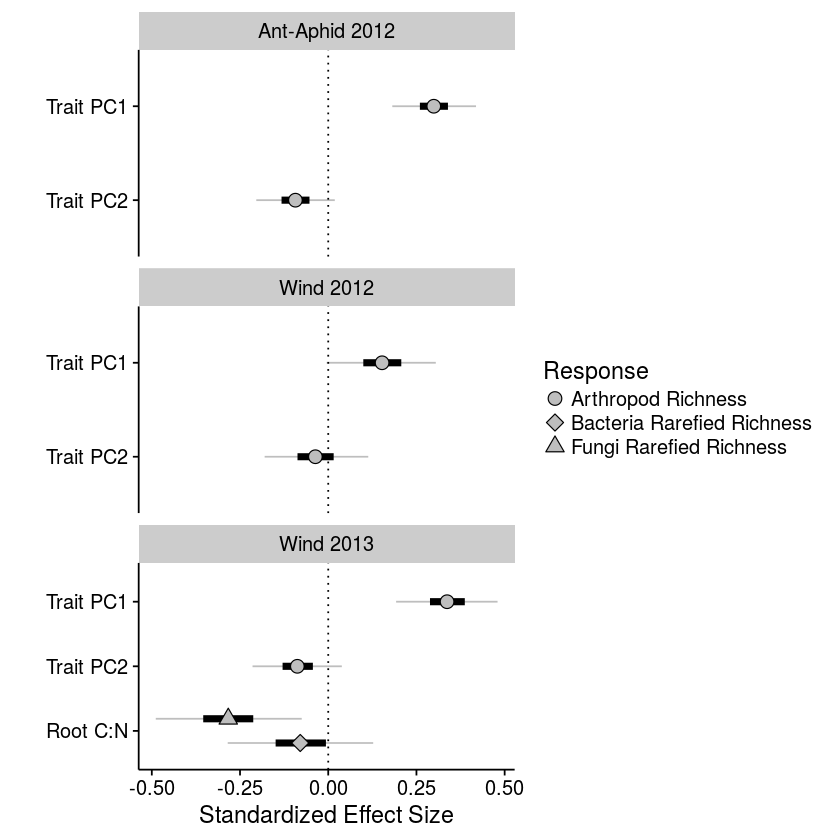

In [40]:

## GATHER PLOT DATA ----

trait.effects.df <- bind_rows(mutate(gather(select(trait.rich.aa.12, b_sc.Trait.PC1, b_sc.Trait.PC2), Trait, Effect_Size), Response = "Arthropod Richness", Experiment_Year = "Ant-Aphid 2012"), 
          mutate(gather(select(trait.rich.wind.12, b_sc.Trait.PC1, b_sc.Trait.PC2), Trait, Effect_Size), Response = "Arthropod Richness", Experiment_Year = "Wind 2012"), 
          mutate(gather(select(trait.rich.wind.13, b_sc.Trait.PC1, b_sc.Trait.PC2), Trait, Effect_Size), Response = "Arthropod Richness", Experiment_Year = "Wind 2013"), 
          mutate(gather(select(trait.rarerich.wind.13, b_sc.log.Root.CN), Trait, Effect_Size), Response = "Fungi Rarefied Richness", Experiment_Year = "Wind 2013"), 
          mutate(gather(select(bact.trait.rarerich.wind.13, b_sc.log.Root.CN), Trait, Effect_Size), Response = "Bacteria Rarefied Richness", Experiment_Year = "Wind 2013")) %>%
  separate(Experiment_Year, into=c("Experiment","Year"), sep = " ", remove=F) 
trait.effects.df$Trait <- factor(trait.effects.df$Trait, 
                                 levels = rev(c("b_sc.Trait.PC1","b_sc.Trait.PC2","b_sc.log.Root.CN")),
                                 labels = rev(c("Trait PC1", "Trait PC2", "Root C:N")))

## MAKE PLOT ----

plot_trait.effects <- ggplot(trait.effects.df, aes(x = Trait, y=Effect_Size, shape=Response)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.975), fun.ymin=function(y) quantile(y,0.025), geom="linerange", color="grey", size=0.5, position=position_dodge(width=0.75)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.75), fun.ymin=function(y) quantile(y,0.25), geom="linerange", color="black", size=2, position=position_dodge(width=0.75)) +
  stat_summary(fun.y = median, size=3.5, fill="grey", position=position_dodge(width=0.75), geom="point") +
  coord_flip() + 
  scale_shape_manual(values = c(21,23,24)) +
  geom_hline(yintercept = 0, linetype="dotted") +
  xlab("") +
  ylab("Standardized Effect Size") +
  facet_wrap(~Experiment_Year, ncol=1, scales = "free_y")
plot_trait.effects
# save_plot(filename = "manuscript/figures/fig_trait_effects.png", plot = plot_trait.effects, base_height = 6, base_width = 8.5)

Plot loadings of plant traits on principal component axes (reproduces Fig. 2). 

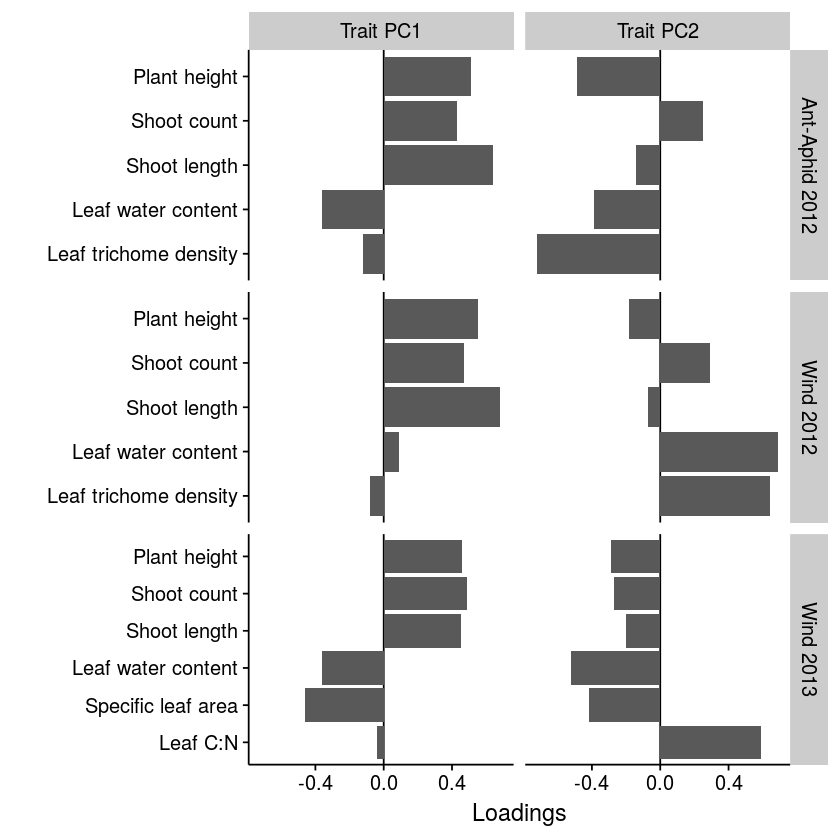

In [41]:

## GATHER PLOT DATA ----

pc.df <- data.frame(Trait.PC1 = c(0.51, 0.43, 0.64, -0.12, -0.36, 0.55, 0.47, 0.68, -0.08, 0.09, 0.46, 0.49, 0.45, -0.36, -0.46, -0.04),
                    Trait.PC2 = c(-0.49, 0.25, -0.14, -0.72, -0.39, -0.18, 0.29, -0.07, 0.64, 0.69, -0.29, -0.27, -0.20, -0.52, -0.42, 0.59),
                    Traits = c(rep(c("Plant height", "Shoot count", "Shoot length", "Leaf trichome density", "Leaf water content"),2),c("Plant height","Shoot count","Shoot length","Leaf water content","Specific leaf area","Leaf C:N")),
                    Experiment = c(rep("Ant-Aphid",5),rep("Wind",5),rep("Wind",6)),
                    Year = c(rep("2012",5),rep("2012",5),rep("2013",6)))
colnames(pc.df)[1:2] <- c("Trait PC1", "Trait PC2")
gather.pc.df <- gather(pc.df, Principal_Component, Value, -Traits, -Experiment, -Year) %>%
  unite(Experiment_Year, Experiment, Year, sep = " ")
gather.pc.df$Traits_ord <- factor(gather.pc.df$Traits, levels=rev(c("Plant height","Shoot count","Shoot length","Leaf water content","Leaf trichome density","Specific leaf area","Leaf C:N")))


## MAKE PLOT ----

plot_pca <- ggplot(gather.pc.df, aes(x=Traits_ord, y=Value)) +
  geom_hline(yintercept = 0, linetype="solid") +
  geom_bar(stat="identity") + 
  coord_flip() + 
  facet_grid(Experiment_Year ~ Principal_Component, drop=T, scales="free_y") +
  xlab("") + ylab("Loadings")
plot_pca
# save_plot(filename = "manuscript/figures/fig_pca.png", plot = plot_pca, base_height=6, base_width=8.5)


Analyze Bayesian linear mixed-effect models to quantify sources of intraspecific trait variation. 

In [42]:

## ANT-APHID TRAIT PC1 2012 ANALYSIS ----

trait.PC1.aa.2012.brm <- general_brm(sc.Trait.PC1~sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.trait.2012)
summary(trait.PC1.aa.2012.brm) 


## ANT-APHID TRAIT PC2 2012 ANALYSIS ----

trait.PC2.aa.2012.brm <- general_brm(sc.Trait.PC2~sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.trait.2012)
summary(trait.PC2.aa.2012.brm) 


## WIND TRAIT PC1 2012 ANALYSIS ----

trait.PC1.wind.2012.brm <- general_brm(sc.Trait.PC1~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2012)
summary(trait.PC1.wind.2012.brm)


## WIND TRAIT PC2 2012 ANALYSIS ----

trait.PC2.wind.2012.brm <- brm(sc.log.trans.Trait.PC2~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2012)
summary(trait.PC2.wind.2012.brm) 


## WIND TRAIT PC1 2013 ANALYSIS ----

trait.PC1.wind.2013.brm <- general_brm(sc.Trait.PC1~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2013)
summary(trait.PC1.wind.2013.brm)


## WIND TRAIT PC2 2013 ANALYSIS ----

trait.PC2.wind.2013.brm <- general_brm(sc.Trait.PC2~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2013)
summary(trait.PC2.wind.2013.brm) 


## WIND ROOT C:N 2013 ANALYSIS ----

root_CN.wind.2013.brm <- general_brm(sc.log.Root.CN~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2013) 
summary(root_CN.wind.2013.brm) 


Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.Trait.PC1 ~ sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 300) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.40      0.30     0.02     1.11       1170 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.42      0.14
sd(sc.Aphid.treatment)                                           0.10      0.07
sd(sc.Ant.mound.dist)                                            0.08      0.06
sd(sc.Aphid.treatment:sc.Ant.mound.dist)         

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.Trait.PC2 ~ sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 300) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.17      0.14     0.01     0.54       1773 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.56      0.16
sd(sc.Aphid.treatment)                                           0.09      0.07
sd(sc.Ant.mound.dist)                                            0.09      0.07
sd(sc.Aphid.treatment:sc.Ant.mound.dist)         

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.Trait.PC1 ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 200) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.11      0.09     0.00     0.33       1803 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.47      0.15     0.24     0.83       1404
sd(sc.Wind.Exposure)                0.17      0.10     0.01     0.41       1619
cor(Intercept,sc.Wind.Exposure)     0.33      0.45    -0.70     0.97       3243
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wind.Exposur

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.log.trans.Trait.PC2 ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: w.trait.2012 (Number of observations: 200) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.20      0.14     0.01     0.53       1180 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.59      0.20     0.31     1.07       1439
sd(sc.Wind.Exposure)                0.10      0.08     0.00     0.30       2136
cor(Intercept,sc.Wind.Exposure)     0.17      0.54    -0.88     0.96       4000
                                Rhat
sd(Intercept)                   1.00


Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.Trait.PC1 ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 200) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.40      0.20     0.04     0.82        843 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.32      0.12     0.13     0.62       1285
sd(sc.Wind.Exposure)                0.15      0.10     0.01     0.37       1520
cor(Intercept,sc.Wind.Exposure)     0.26      0.47    -0.74     0.96       3298
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wind.Exposur

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.Trait.PC2 ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 200) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.18      0.12     0.01     0.46       1189 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.30      0.14     0.06     0.61       1062
sd(sc.Wind.Exposure)                0.15      0.10     0.01     0.39       1704
cor(Intercept,sc.Wind.Exposure)     0.17      0.51    -0.86     0.96       3126
                                Rhat
sd(Intercept)                   1.01
sd(sc.Wind.Exposur

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.log.Root.CN ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 141) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.31      0.19     0.01     0.73       1053 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.13      0.10     0.00     0.39       2237
sd(sc.Wind.Exposure)                0.10      0.08     0.00     0.30       4000
cor(Intercept,sc.Wind.Exposure)     0.03      0.58    -0.94     0.95       4000
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wind.Expos

Plot variance explained by different sources of trait variation (reproduces Fig. 3).

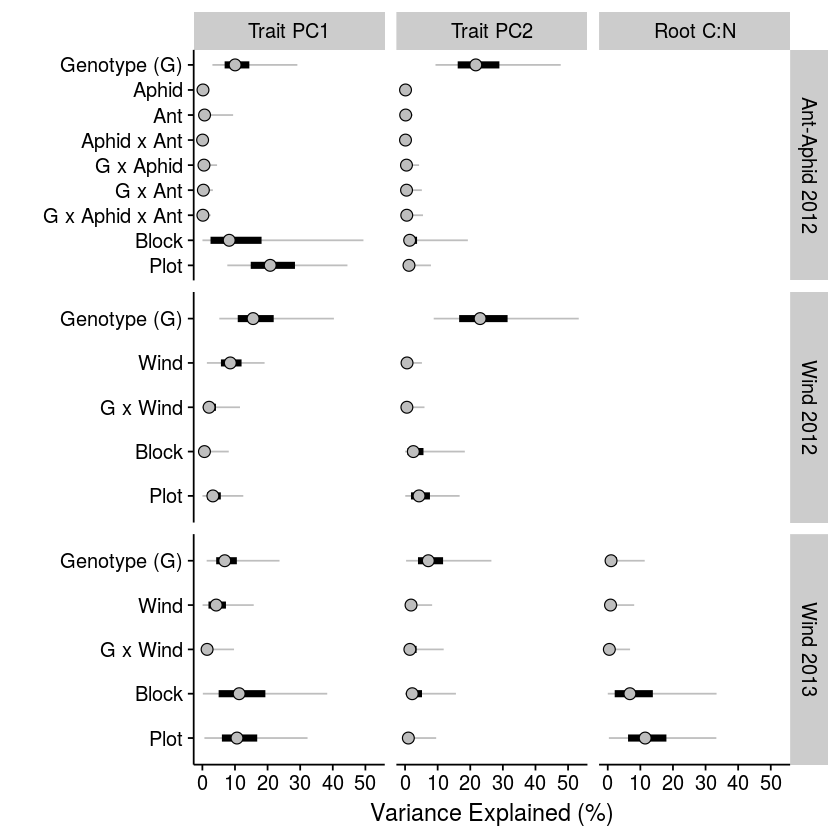

In [43]:

## GATHER POSTERIOR SD ESTIMATES FROM STATISTICAL MODELS ----

wind_SDs <- bind_rows(
  mutate(posterior_SDs(trait.PC1.wind.2012.brm, df=w.trait.2012, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2012", Response="Trait PC1"),
  mutate(posterior_SDs(trait.PC2.wind.2012.brm, df=w.trait.2012, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2012", Response="Trait PC2"), 
  mutate(posterior_SDs(trait.PC1.wind.2013.brm, df=w.trait.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Trait PC1"), 
  mutate(posterior_SDs(trait.PC2.wind.2013.brm, df=w.trait.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Trait PC2"), 
  mutate(posterior_SDs(root_CN.wind.2013.brm, df=w.trait.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Root C:N"), 
)

ant.aphid_SDs <- bind_rows(
  mutate(posterior_SDs(trait.PC1.aa.2012.brm, df=aa.trait.2012, FE_formula = "~sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Trait PC1"), 
  mutate(posterior_SDs(trait.PC2.aa.2012.brm, df=aa.trait.2012, FE_formula = "~sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Trait PC2"), 
)


## CALCULATE VARIANCE EXPLAINED FOR SOURCES OF TRAIT VARIATION IN WIND EXPERIMENT ----

wind.var.df <- wind_SDs %>% 
  transmute("Genotype (G)" = sd_Genotype__Intercept^2 /        (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Wind =       sd_sc.Wind.Exposure^2 /           (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Wind" =     sd_Genotype__sc.Wind.Exposure^2 / (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Block =    sd_Block__Intercept^2 /           (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Plot =     sd_Plot_code__Intercept^2 /       (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            sample = sample, Experiment = Experiment, Year = Year, Response = Response) %>%
  gather(key = term, value = percent.variance, -(sample:Response)) 


## CALCULATE VARIANCE EXPLAINED FOR SOURCES OF TRAIT VARIATION IN ANT-APHID EXPERIMENT ----

aa.var.df <- ant.aphid_SDs %>% 
  transmute("Genotype (G)" =    sd_Genotype__Intercept^2 /                            (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Aphid =             sd_sc.Aphid.treatment^2 /                             (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Ant =               sd_sc.Ant.mound.dist^2 /                              (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "Aphid x Ant" =     sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 /           (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Aphid" =       sd_Genotype__sc.Aphid.treatment^2 /                   (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Ant" =         sd_Genotype__sc.Ant.mound.dist^2 /                    (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Aphid x Ant" = sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 / (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Block =             sd_Block__Intercept^2 /                               (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Plot =              sd_Plot_code__Intercept^2 /                           (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            sample = sample, Experiment = Experiment, Year = Year, Response = Response) %>%
  gather(key = term, value = percent.variance, -(sample:Response)) 


## BIND & ORGANIZE DATA FOR PLOTTING ----

var.df <- bind_rows(wind.var.df, aa.var.df) %>% unite(Experiment_Year, Experiment, Year, sep = " ", remove = F)
var.df$term <- factor(var.df$term)
var.df$term_ord <- factor(var.df$term, levels=c("Plot","Block","G x Aphid x Ant","G x Ant","G x Aphid","G x Wind","Aphid x Ant","Ant","Aphid","Wind","Genotype (G)")) # "Soil PC2","Soil PC1", "Root C:N","Trait PC2","Trait PC1"

plot_traits <- filter(var.df, Response%in%c("Trait PC1","Trait PC2","Root C:N"))
plot_traits$Response_ord <- factor(plot_traits$Response, levels = c("Trait PC1","Trait PC2", "Root C:N")) 


## MAKE PLOT ----

traits_gg <- ggplot(plot_traits, aes(x=term_ord, y=percent.variance)) + # , fill=Response_ord
  stat_summary(fun.ymax=function(y) quantile(y,0.975), fun.ymin=function(y) quantile(y,0.025), geom="linerange", color="grey", size=0.5, position=position_dodge(width=0.75)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.75), fun.ymin=function(y) quantile(y,0.25), geom="linerange", color="black", size=2, position=position_dodge(width=0.75)) +
  stat_summary(fun.y = median, size=3, shape=21, fill="grey", position=position_dodge(width=0.75), geom="point") +
  coord_flip() +
  ylab("Variance Explained (%)") +
  xlab("") +
  scale_y_continuous(breaks = c(0, 0.1, 0.2, 0.3, 0.4, 0.5), labels=c(0, 10, 20, 30, 40, 50)) +
  facet_grid(Experiment_Year ~ Response_ord, scales="free_y") + 
  theme_cowplot()
traits_gg 
# save_plot(filename = "manuscript/figures/fig_trait_variance.png", plot = traits_gg, base_height = 6, base_width = 8)


Plot indirect effects of trait plasticity and genetic variation on species richness (reproduces Fig. 4).

Variation,total.indirect.effect
Genetic,0.1711153
Plastic,0.4660261


Variation,total.indirect.effect
Genetic,0.1025939
Plastic,0.1606517


Variation,total.indirect.effect
Genetic,0.1353412
Plastic,0.4600680


Variation,total.indirect.effect
Genetic,0.02990827
Plastic,0.22649432


Variation,total.indirect.effect
Genetic,0.009778676
Plastic,0.074053588


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

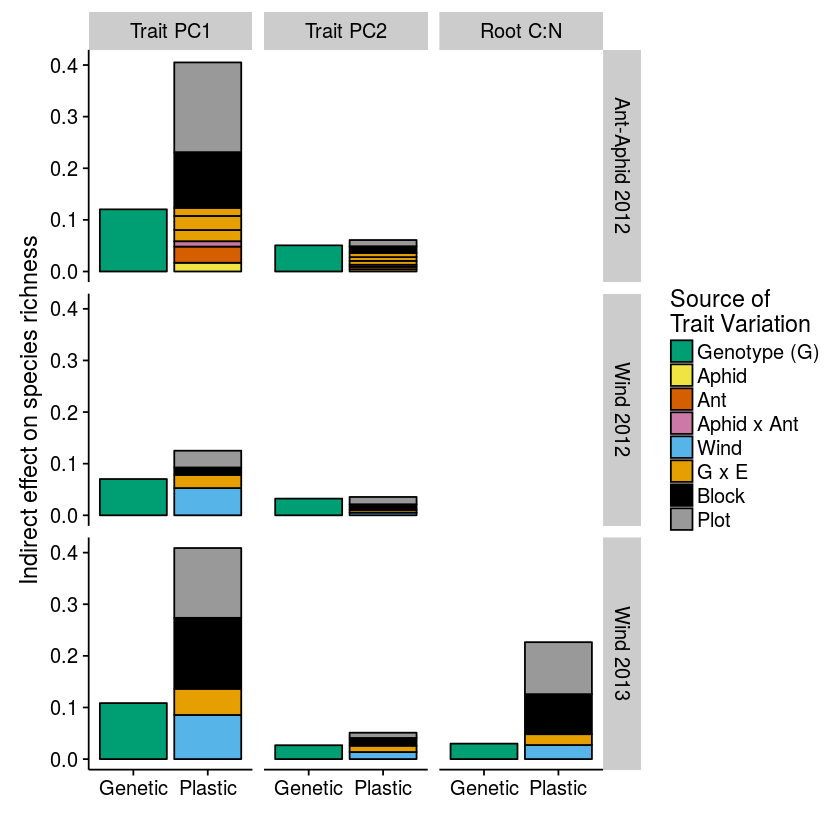

In [44]:
## GATHER POSTERIOR SD ESTIMATES FROM TRAIT EFFECTS ON SPECIES RICHNESS ----

lanphere_trait_regs <- bind_rows(
  mutate(posterior_SDs(trait.rich.aa.2012.brm, df=aa.trait.arth.2012, FE_formula = "~sc.Trait.PC1+sc.Trait.PC2+sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Arthropod Richness"), #Response="scale(log(Arthropod Richness + 1))"),
  mutate(posterior_SDs(trait.rich.wind.2012.brm, df=w.trait.arth.2012, FE_formula = "~sc.Trait.PC1+sc.Trait.PC2+sc.Wind.Exposure"), Experiment="Wind", Year="2012", Response="Arthropod Richness"), #Response="scale(log(Arthropod Richness + 1))"),
  mutate(posterior_SDs(trait.rich.wind.2013.brm, df=w.trait.arth.2013, FE_formula = "~sc.Trait.PC1+sc.Trait.PC2+sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Arthropod Richness"), #Response="scale(log(Arthropod Richness + 1))"),
  mutate(posterior_SDs(trait.rarerich.wind.2013.brm, df=w.trait.fung.2013, FE_formula = "~sc.log.Root.CN+sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Fungi Rarefied Richness"), #Response="scale(Fungi Rarefied Richness)"),
  mutate(posterior_SDs(bact.trait.rarerich.wind.2013.brm, df=w.trait.bact.2013, FE_formula = "~sc.log.Root.CN+sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Bacteria Rarefied Richness") #Response="scale(Bacteria Rarefied Richness)")
)


## CALCULATE INDIRECT EFFECTS IN ANT-APHID EXPERIMENT ----

# calculate SD for each source of variation
ant.aphid.trait.SD <- ant.aphid_SDs %>% 
  gather(key = term, value = posterior_SD, -sample, -(Experiment:Response)) %>%
  filter(Response %in% c("Trait PC1", "Trait PC2")) %>%
  group_by(term, Response, Year) %>%
  summarise(median = median(posterior_SD)) 
ant.aphid.trait.SD.medians <- ant.aphid.trait.SD %>%
  select(term, Year, Response, median) %>%
  spread(key=Response, value=median) %>%
  filter(term != "sd_Intercept") %>% # non-informative
  data.frame()

aa.trait.2012.medians <- ant.aphid.trait.SD.medians %>%
  filter(Year == "2012", term != "sigma") %>%
  mutate(Variation = c("Plastic", "Genetic", rep("Plastic",7)))

# calculate SD for trait effect on species richness
ant.aphid.arth.SD <- lanphere_trait_regs %>% 
  select(Experiment, Year, Response, sample, sd_sc.Trait.PC1, sd_sc.Trait.PC2, 
         sd_sc.Aphid.treatment, sd_sc.Ant.mound.dist, sd_sc.Aphid.treatment.sc.Ant.mound.dist, 
         sd_Genotype__Intercept, sd_Genotype__sc.Aphid.treatment, sd_Genotype__sc.Ant.mound.dist, sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist,
         sd_Block__Intercept, sd_Plot_code__Intercept) %>%
  gather(key = term, value = posterior_SD, -sample, -(Experiment:Response)) %>%
  filter(Response == "Arthropod Richness", Experiment == "Ant-Aphid") %>%
  group_by(term, Response, Year) %>%
  summarise(median = median(posterior_SD))
ant.aphid.arth.SD.medians <- ant.aphid.arth.SD %>%
  select(term, Year, Response, median) %>%
  spread(key=Response, value=median) %>%
  filter(term != "sd_Intercept") %>% # non-informative
  data.frame()

aa.trait.rich.2012 <- ant.aphid.arth.SD.medians %>%
  filter(term %in% c("sd_sc.Trait.PC1","sd_sc.Trait.PC2"), Year == "2012") %>%
  spread(term, Arthropod.Richness)

# calculate indirect effects by multiplying SDs together
aa.partition.2012 <- aa.trait.2012.medians
aa.partition.2012$Trait.PC1 <- aa.partition.2012$Trait.PC1*aa.trait.rich.2012$sd_sc.Trait.PC1
aa.partition.2012$Trait.PC2 <- aa.partition.2012$Trait.PC2*aa.trait.rich.2012$sd_sc.Trait.PC2
aa.partition.2012$term_alt <- factor(c("Block","Genotype (G)","G x E","G x E", "G x E", "Plot", "Ant", "Aphid", "Aphid x Ant"),
                                     levels=c("Genotype (G)","Aphid","Ant","Aphid x Ant","G x E","Block","Plot"))

group_by(aa.partition.2012, Variation) %>% summarise(total.indirect.effect = sum(Trait.PC1) + sum(Trait.PC2))


## CALCULATE INDIRECT EFFECTS IN WIND EXPERIMENT ----

# calculate SD for each source of variation
wind.trait.SD <- wind_SDs %>% 
  gather(key = term, value = posterior_SD, -sample, -(Experiment:Response)) %>%
  filter(Response %in% c("Trait PC1", "Trait PC2", "Root C:N")) %>%
  group_by(term, Response, Year) %>%
  summarise(median = median(posterior_SD))
wind.trait.SD.medians <- wind.trait.SD %>%
  select(term, Year, Response, median) %>%
  spread(key=Response, value=median) %>%
  filter(term != "sd_Intercept") %>% # non-informative
  data.frame()

w.trait.2012.medians <- wind.trait.SD.medians %>%
  select(-Root.C.N) %>%
  filter(Year == "2012", term != "sigma") %>%
  mutate(Variation = c("Plastic", "Genetic", rep("Plastic",3)))

w.trait.2013.medians <- wind.trait.SD.medians %>%
  select(-Root.C.N) %>%
  filter(Year == "2013", term != "sigma") %>%
  mutate(Variation = c("Plastic", "Genetic", rep("Plastic",3)))

w.root.2013.medians <- wind.trait.SD.medians %>%
  select(-Trait.PC1, -Trait.PC2) %>%
  filter(Year == "2013", term != "sigma") %>%
  mutate(Variation = c("Plastic", "Genetic", rep("Plastic",3)))

# calculate SD for trait effect on species richness
wind.arth.SD <- lanphere_trait_regs %>% 
  select(Experiment, Year, Response, sample, sd_sc.Trait.PC1, sd_sc.Trait.PC2, 
         sd_sc.Wind.Exposure, sd_Genotype__Intercept, sd_Genotype__sc.Wind.Exposure, 
         sd_Block__Intercept, sd_Plot_code__Intercept) %>%
  gather(key = term, value = posterior_SD, -sample, -(Experiment:Response)) %>%
  filter(Response == "Arthropod Richness", Experiment == "Wind") %>%
  group_by(term, Response, Year) %>%
  summarise(median = median(posterior_SD))
wind.arth.SD.medians <- wind.arth.SD %>%
  select(term, Year, Response, median) %>%
  spread(key=Response, value=median) %>%
  filter(term != "sd_Intercept") %>% # non-informative
  data.frame()

wind.below.SD <- lanphere_trait_regs %>% # read.csv("output_brms/lanphere_trait_regs.csv") %>%
  select(Experiment, Year, Response, sample, sd_sc.log.Root.CN, sd_sc.Wind.Exposure, 
         sd_Genotype__Intercept, sd_Genotype__sc.Wind.Exposure, 
         sd_Block__Intercept, sd_Plot_code__Intercept) %>%
  gather(key = term, value = posterior_SD, -sample, -(Experiment:Response)) %>%
  filter(Response %in% c("Fungi Rarefied Richness","Bacteria Rarefied Richness")) %>%
  group_by(term, Response) %>%
  summarise(median = median(posterior_SD))
wind.below.SD.medians <- wind.below.SD %>%
  select(term, Response, median) %>%
  spread(key=Response, value=median) %>%
  data.frame()

w.trait.rich.2012 <- wind.arth.SD.medians %>%
  filter(term %in% c("sd_sc.Trait.PC1","sd_sc.Trait.PC2"), Year == "2012") %>%
  spread(term, Arthropod.Richness)

w.trait.rich.2013 <- wind.arth.SD.medians %>%
  filter(term %in% c("sd_sc.Trait.PC1","sd_sc.Trait.PC2"), Year == "2013") %>%
  spread(term, Arthropod.Richness)

w.trait.microbe.2013 <- filter(wind.below.SD.medians, term == "sd_sc.log.Root.CN")  


# calculate indirect effects by multiplying SDs together
w.partition.2012 <- w.trait.2012.medians
w.partition.2012$Trait.PC1 <- w.trait.2012.medians$Trait.PC1*w.trait.rich.2012$sd_sc.Trait.PC1
w.partition.2012$Trait.PC2 <- w.trait.2012.medians$Trait.PC2*w.trait.rich.2012$sd_sc.Trait.PC2
w.partition.2012$term_alt <- factor(c("Block","Genotype (G)","G x E","Plot", "Wind"),
                                     levels=c("Genotype (G)","Wind","G x E","Block","Plot"))

group_by(w.partition.2012, Variation) %>% summarise(total.indirect.effect = sum(Trait.PC1) + sum(Trait.PC2)) # 1.5x

w.partition.2013 <- w.trait.2013.medians
w.partition.2013$Trait.PC1 <- w.partition.2013$Trait.PC1*w.trait.rich.2013$sd_sc.Trait.PC1
w.partition.2013$Trait.PC2 <- w.partition.2013$Trait.PC2*w.trait.rich.2013$sd_sc.Trait.PC2
w.partition.2013$term_alt <- factor(c("Block","Genotype (G)","G x E","Plot", "Wind"),
                                    levels=c("Genotype (G)","Wind","G x E","Block","Plot"))
group_by(w.partition.2013, Variation) %>% summarise(total.indirect.effect = sum(Trait.PC1) + sum(Trait.PC2)) # 3.6x

w.root.Fungi.2013 <- w.root.2013.medians  
w.root.Fungi.2013$Root.C.N <- w.root.Fungi.2013$Root.C.N*w.trait.microbe.2013$Fungi.Rarefied.Richness
w.root.Fungi.2013$term_alt <- factor(c("Block","Genotype (G)","G x E","Plot", "Wind"),
                                    levels=c("Genotype (G)","Wind","G x E","Block","Plot"))
group_by(w.root.Fungi.2013, Variation) %>% summarise(total.indirect.effect = sum(Root.C.N)) # 7x

w.root.Bacteria.2013 <- w.root.2013.medians
w.root.Bacteria.2013$Root.C.N <- w.root.Bacteria.2013$Root.C.N*w.trait.microbe.2013$Bacteria.Rarefied.Richness
w.root.Bacteria.2013$term_alt <- factor(c("Block","Genotype (G)","G x E","Plot", "Wind"),
                                     levels=c("Genotype (G)","Wind","G x E","Block","Plot"))
group_by(w.root.Bacteria.2013, Variation) %>% summarise(total.indirect.effect = sum(Root.C.N)) # 7x

w.root.microbes.2013 <- bind_rows(mutate(w.root.Fungi.2013, Community = "Root-fungi"),
                                  mutate(w.root.Bacteria.2013, Community = "Root-bacteria"))


## PLOT INDIRECT EFFECTS OF TRAIT PLASTICITY & GENETIC VARIATION ----

# gather plot data
var_data <- bind_rows(gather(mutate(aa.partition.2012, Community = "Arthropods", Experiment_Year = "Ant-Aphid 2012"), Traits, Effect_Size, -term, -Year, -Variation, -Community, -term_alt, -Experiment_Year),
          gather(mutate(w.partition.2012, Community = "Arthropods", Experiment_Year = "Wind 2012"), Traits, Effect_Size, -term, -Year, -Variation, -Community, -term_alt, -Experiment_Year),
          gather(mutate(w.partition.2013, Community = "Arthropods", Experiment_Year = "Wind 2013"), Traits, Effect_Size, -term, -Year, -Variation, -Community, -term_alt, -Experiment_Year),
          gather(mutate(w.root.microbes.2013, Experiment_Year = "Wind 2013"), Traits, Effect_Size, -term, -Year, -Variation, -Community, -term_alt, -Experiment_Year)) %>%
  filter(Community %in% c("Arthropods","Root-fungi")) # only keeping Root-Fungi because it Root C:N had the largest effect on it, plus the relative importance of Genetic vs. plastic trait variation is the same as for root-microbes
var_data$term_alt <- factor(var_data$term_alt)
var_data$Traits <- factor(var_data$Traits) 
var_data$Traits <- factor(var_data$Traits, levels=c("Trait.PC1","Trait.PC2","Root.C.N"), labels=c("Trait PC1","Trait PC2", "Root C:N"))
var_data$term_alt_ord <- factor(var_data$term_alt, levels = c("Genotype (G)", "Aphid", "Ant", "Aphid x Ant", "Wind", "G x E", "Block", "Plot"))

# color-blind friendly palette
lanphere_pal <- c("#009E73","#F0E442","#D55E00","#CC79A7","#56B4E9","#E69F00","#000000","#999999")

# make plot
plot_var <- var_data %>%
  ggplot(., aes(x=Variation, y=Effect_Size, fill=term_alt_ord)) +
  geom_bar(stat="identity", color = "black", position = position_stack(reverse=T)) +
  scale_fill_manual(values = lanphere_pal, name = "Source of\nTrait Variation") +
  facet_grid(Experiment_Year~Traits) +
  ylab("Indirect effect on species richness") +
  xlab("")
plot_var
# save_plot(filename = "manuscript/figures/fig_genetic_vs_plastic.png", plot = plot_var, base_height = 6, base_width = 8.5)


-----------  BEGIN CODE FOR SUPPLEMENTARY MATERIAL ---------------

Analyses and plots of Bayesian linear mixed-effect models that quantify sources of variation for individual traits.

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(leaf_trichome.density + 1)) ~ sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 114) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.23      0.20     0.01     0.72       1744 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.58      0.19
sd(sc.Aphid.treatment)                                           0.32      0.19
sd(sc.Ant.mound.dist)                                            0.14      0.11
sd(sc.Aphid.treatment:sc

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(leaf_WC)) ~ sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 114) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.29      0.24     0.01     0.92       1460 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.26      0.15
sd(sc.Aphid.treatment)                                           0.14      0.11
sd(sc.Ant.mound.dist)                                            0.17      0.13
sd(sc.Aphid.treatment:sc.Ant.mound.dist)  

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling
Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(Height) ~ sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 257) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.31      0.26     0.01     0.98       1294 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.61      0.18
sd(sc.Aphid.treatment)                                           0.07      0.06
sd(sc.Ant.mound.dist)                                            0.09      0.06
sd(sc.Aphid.treatment:sc.Ant.mound.dist)        

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(all.shoot.count)) ~ sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 257) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.48      0.26     0.12     1.10       1499 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.43      0.14
sd(sc.Aphid.treatment)                                           0.13      0.09
sd(sc.Ant.mound.dist)                                            0.13      0.09
sd(sc.Aphid.treatment:sc.Ant.mound

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(mature.shoot.avg.length + 1)) ~ sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 257) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.44      0.32     0.02     1.24       1200 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.45      0.14
sd(sc.Aphid.treatment)                                           0.08      0.06
sd(sc.Ant.mound.dist)                                            0.08      0.06
sd(sc.Aphid.treatment:

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(leaf_trichome.density + 1)) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 149) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.12      0.09     0.01     0.34       2265 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.70      0.21     0.39     1.22       1461
sd(sc.Wind.Exposure)                0.11      0.09     0.00     0.33       1794
cor(Intercept,sc.Wind.Exposure)     0.04      0.54    -0.92     0.94       4000
                                Rhat
sd(Intercept)                 

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(leaf_WC)) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 149) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.21      0.14     0.01     0.55       1122 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.41      0.16     0.17     0.79       1340
sd(sc.Wind.Exposure)                0.16      0.12     0.01     0.45       1700
cor(Intercept,sc.Wind.Exposure)    -0.25      0.51    -0.96     0.83       3522
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wind.

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(Height) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 185) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.12      0.10     0.01     0.36       1939 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.63      0.18     0.37     1.06       1290
sd(sc.Wind.Exposure)                0.11      0.08     0.00     0.29       2293
cor(Intercept,sc.Wind.Exposure)    -0.41      0.48    -0.98     0.77       4000
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wind.Exposu

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(all.shoot.count)) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 186) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.10      0.08     0.00     0.31       2237 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.55      0.17     0.30     0.97       1627
sd(sc.Wind.Exposure)                0.16      0.11     0.01     0.42       1412
cor(Intercept,sc.Wind.Exposure)     0.27      0.47    -0.77     0.96       4000
                                Rhat
sd(Intercept)                   1.00
sd(

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(all.shoot.avg.length) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 186) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.15      0.11     0.01     0.41       1625 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.43      0.14     0.21     0.78       1586
sd(sc.Wind.Exposure)                0.24      0.11     0.05     0.50       1654
cor(Intercept,sc.Wind.Exposure)     0.55      0.36    -0.34     0.98       2460
                                Rhat
sd(Intercept)                   1.00
sd(

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(leaf_C_N)) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 102) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.32      0.19     0.02     0.72        778 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.59      0.19     0.28     1.05       1244
sd(sc.Wind.Exposure)                0.17      0.12     0.01     0.46       1470
cor(Intercept,sc.Wind.Exposure)    -0.10      0.51    -0.93     0.87       3177
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wind

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(leaf_WC)) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 156) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.12      0.10     0.01     0.37       2228 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.51      0.17     0.26     0.93       1413
sd(sc.Wind.Exposure)                0.14      0.11     0.01     0.40       1369
cor(Intercept,sc.Wind.Exposure)    -0.24      0.50    -0.96     0.81       4000
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wind.

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(SLA)) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 157) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.20      0.14     0.01     0.53       1286 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.57      0.19     0.29     1.02       1422
sd(sc.Wind.Exposure)                0.13      0.10     0.00     0.37       1823
cor(Intercept,sc.Wind.Exposure)    -0.13      0.52    -0.94     0.89       4000
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wind.Expo

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(Height) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 165) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.34      0.19     0.03     0.76        706 1.01

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.34      0.12     0.16     0.62       1392
sd(sc.Wind.Exposure)                0.22      0.10     0.07     0.45       1985
cor(Intercept,sc.Wind.Exposure)     0.72      0.28    -0.05     0.99       2129
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wind.Exposu

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(all.shoot.count)) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 165) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.29      0.18     0.01     0.70        466 1.01

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.28      0.13     0.07     0.58       1314
sd(sc.Wind.Exposure)                0.12      0.09     0.01     0.34       2468
cor(Intercept,sc.Wind.Exposure)     0.35      0.51    -0.80     0.98       4000
                                Rhat
sd(Intercept)                   1.00
sd(

Warning message:
“Rows containing NAs were excluded from the model”Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(all.shoot.avg.length) ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 165) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.77      0.24     0.36     1.31       1614 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.28      0.11     0.11     0.57       1229
sd(sc.Wind.Exposure)                0.09      0.07     0.00     0.26       1971
cor(Intercept,sc.Wind.Exposure)    -0.12      0.54    -0.95     0.88       4000
                                Rhat
sd(Intercept)                   1.00
sd(

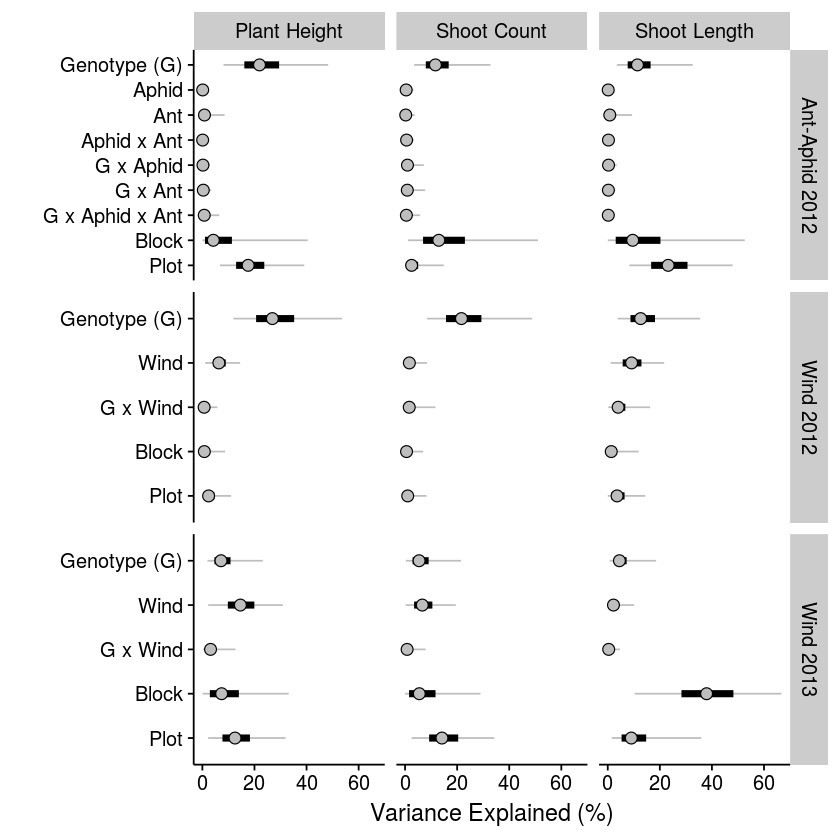

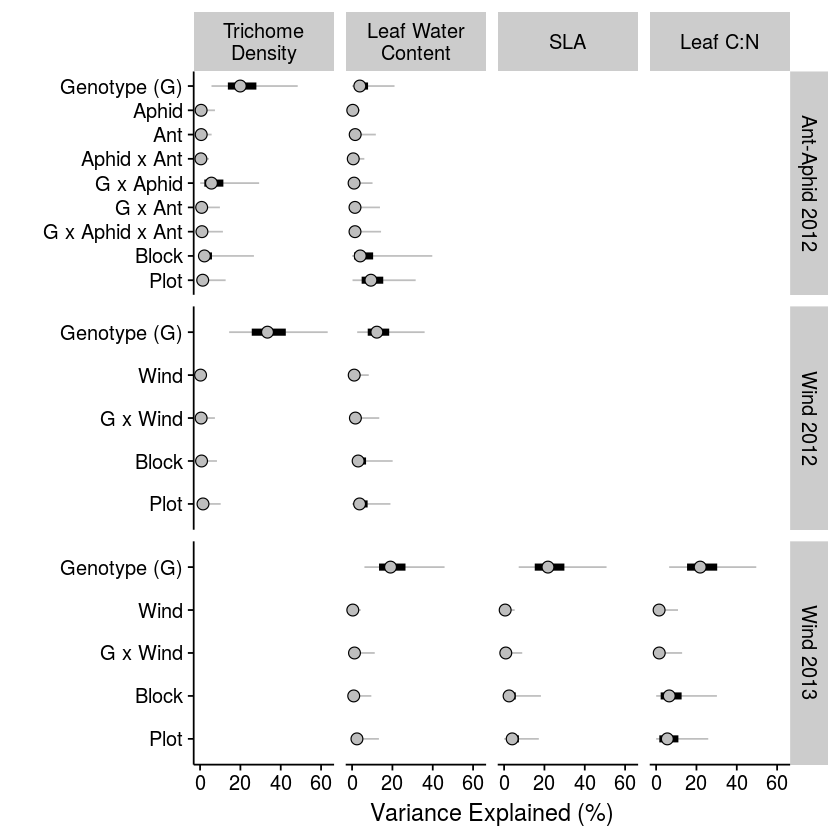

In [45]:

## ANT-APHID 2012 ----

trichomes.aa.2012 <- general_brm(scale(log(leaf_trichome.density+1))~sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.trait.2012)
summary(trichomes.aa.2012) 

leafWC.aa.2012 <- general_brm(scale(log(leaf_WC))~sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.trait.2012)
summary(leafWC.aa.2012) 

height.aa.2012 <- general_brm(scale(Height)~sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.trait.2012)
summary(height.aa.2012) 

shoot.count.aa.2012 <- general_brm(scale(log(all.shoot.count))~sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.trait.2012)
summary(shoot.count.aa.2012) 

shoot.length.aa.2012 <- general_brm(scale(log(mature.shoot.avg.length+1))~sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.trait.2012)
summary(shoot.length.aa.2012) 


## WIND 2012 ----

trichomes.w.2012 <- general_brm(scale(log(leaf_trichome.density+1))~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2012)
summary(trichomes.w.2012) 

leafWC.w.2012 <- general_brm(scale(log(leaf_WC))~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2012)
summary(leafWC.w.2012) 

height.w.2012 <- general_brm(scale(Height)~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2012)
summary(height.w.2012) 

shoot.count.w.2012 <- general_brm(scale(log(all.shoot.count))~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2012)
summary(shoot.count.w.2012) 

shoot.length.w.2012 <- general_brm(scale(all.shoot.avg.length)~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2012)
summary(shoot.length.w.2012) 


## WIND 2013 ----

leafCN.w.2013 <- general_brm(scale(log(leaf_C_N))~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2013)
summary(leafCN.w.2013) 

leafWC.w.2013 <- general_brm(scale(log(leaf_WC))~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2013)
summary(leafWC.w.2013) 

SLA.w.2013 <- general_brm(scale(log(SLA))~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2013)
summary(SLA.w.2013) 

height.w.2013 <- general_brm(scale(Height)~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2013)
summary(height.w.2013) 

shoot.count.w.2013 <- general_brm(scale(log(all.shoot.count))~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2013)
summary(shoot.count.w.2013) 

shoot.length.w.2013 <- general_brm(scale(all.shoot.avg.length)~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.trait.2013)
summary(shoot.length.w.2013) 


## CALCULATE POSTERIOR SD ESTIMATES ----

wind_SDs <- bind_rows(
  mutate(posterior_SDs(trichomes.w.2012, df=w.trait.2012, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2012", Response="Trichome Density"),
  mutate(posterior_SDs(leafWC.w.2012, df=w.trait.2012, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2012", Response="Leaf Water Content"),
  mutate(posterior_SDs(height.w.2012, df=w.trait.2012, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2012", Response="Plant Height"),
  mutate(posterior_SDs(shoot.count.w.2012, df=w.trait.2012, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2012", Response="Shoot Count"),
  mutate(posterior_SDs(shoot.length.w.2012, df=w.trait.2012, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2012", Response="Shoot Length"),
  mutate(posterior_SDs(leafCN.w.2013, df=w.trait.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Leaf C:N"),
  mutate(posterior_SDs(leafWC.w.2013, df=w.trait.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Leaf Water Content"),
  mutate(posterior_SDs(SLA.w.2013, df=w.trait.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="SLA"),
  mutate(posterior_SDs(height.w.2013, df=w.trait.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Plant Height"),
  mutate(posterior_SDs(shoot.count.w.2013, df=w.trait.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Shoot Count"),
  mutate(posterior_SDs(shoot.length.w.2013, df=w.trait.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Shoot Length"),
)

ant.aphid_SDs <- bind_rows(
  mutate(posterior_SDs(trichomes.aa.2012, df=aa.trait.2012, FE_formula = "~sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Trichome Density"),
  mutate(posterior_SDs(leafWC.aa.2012, df=aa.trait.2012, FE_formula = "~sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Leaf Water Content"),
  mutate(posterior_SDs(height.aa.2012, df=aa.trait.2012, FE_formula = "~sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Plant Height"),
  mutate(posterior_SDs(shoot.count.aa.2012, df=aa.trait.2012, FE_formula = "~sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Shoot Count"),
  mutate(posterior_SDs(shoot.length.aa.2012, df=aa.trait.2012, FE_formula = "~sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Shoot Length"),
)


## CALCULATE VARIANCE EXPLAINED FOR DIFFERENT SOURCES ----
wind.var.df <- wind_SDs %>% 
  transmute("Genotype (G)" = sd_Genotype__Intercept^2 /        (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Wind =       sd_sc.Wind.Exposure^2 /           (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Wind" =     sd_Genotype__sc.Wind.Exposure^2 / (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Block =    sd_Block__Intercept^2 /           (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Plot =     sd_Plot_code__Intercept^2 /       (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            sample = sample, Experiment = Experiment, Year = Year, Response = Response) %>%
  gather(key = term, value = percent.variance, -(sample:Response)) 

aa.var.df <- ant.aphid_SDs %>% 
  transmute("Genotype (G)" =    sd_Genotype__Intercept^2 /                            (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Aphid =             sd_sc.Aphid.treatment^2 /                             (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Ant =               sd_sc.Ant.mound.dist^2 /                              (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "Aphid x Ant" =     sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 /           (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Aphid" =       sd_Genotype__sc.Aphid.treatment^2 /                   (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Ant" =         sd_Genotype__sc.Ant.mound.dist^2 /                    (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Aphid x Ant" = sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 / (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Block =             sd_Block__Intercept^2 /                               (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Plot =              sd_Plot_code__Intercept^2 /                           (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            sample = sample, Experiment = Experiment, Year = Year, Response = Response) %>%
  gather(key = term, value = percent.variance, -(sample:Response)) 


## BIND AND ORGANIZE DATA FOR PLOTTING ----

var.df <- bind_rows(wind.var.df, aa.var.df) %>% unite(Experiment_Year, Experiment, Year, sep = " ", remove = F)
var.df$term <- factor(var.df$term)
var.df$term_ord <- factor(var.df$term, levels=c("Plot","Block","G x Aphid x Ant","G x Ant","G x Aphid","G x Wind","Aphid x Ant","Ant","Aphid","Wind","Genotype (G)")) # "Soil PC2","Soil PC1", "Root C:N","Trait PC2","Trait PC1"


## PLOT GROWTH TRAITS ----

growth.traits <- filter(var.df, Response %in% c("Plant Height","Shoot Count","Shoot Length"))
growth.traits$Response_ord <- factor(growth.traits$Response, levels=c("Plant Height", "Shoot Count", "Shoot Length"))

plot.growth.traits <- ggplot(growth.traits, aes(x=term_ord, y=percent.variance)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.975), fun.ymin=function(y) quantile(y,0.025), geom="linerange", color="grey", size=0.5, position=position_dodge(width=0.75)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.75), fun.ymin=function(y) quantile(y,0.25), geom="linerange", color="black", size=2, position=position_dodge(width=0.75)) +
  stat_summary(fun.y = median, size=3, shape=21, fill="grey", position=position_dodge(width=0.75), geom="point") +   
  coord_flip() +
  ylab("Variance Explained (%)") +
  xlab("") +
  scale_y_continuous(breaks = c(0, 0.2, 0.4, 0.6), labels=c(0, 20, 40, 60)) +
  facet_grid(Experiment_Year~Response_ord, scales = "free_y") +
  theme_cowplot()
plot.growth.traits
# save_plot(filename = "manuscript/figures/fig_growth_traits_GxE.png", plot = plot.growth.traits, base_height = 6, base_width = 8)

  
## PLOT LEAF QUALITY TRAITS ----
 
# function for plotting long labels in facet_grid
str_wrap_factor <- function(x, ...) {
  levels(x) <- str_wrap(levels(x), ...)
  x
}
      
      
leaf.quality <- filter(var.df, Response %in% c("Trichome Density","Leaf Water Content","SLA","Leaf C:N"))
leaf.quality$Response_ord <- factor(leaf.quality$Response, levels=c("Trichome Density","Leaf Water Content","SLA","Leaf C:N"))
leaf.quality$Response_ord <- str_wrap_factor(leaf.quality$Response_ord, width = 15)
      
plot.leaf.quality <- ggplot(leaf.quality, aes(x=term_ord, y=percent.variance)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.975), fun.ymin=function(y) quantile(y,0.025), geom="linerange", color="grey", size=0.5, position=position_dodge(width=0.75)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.75), fun.ymin=function(y) quantile(y,0.25), geom="linerange", color="black", size=2, position=position_dodge(width=0.75)) +
  stat_summary(fun.y = median, size=3, shape=21, fill="grey", position=position_dodge(width=0.75), geom="point") + 
  coord_flip() +
  ylab("Variance Explained (%)") +
  xlab("") +
  scale_y_continuous(breaks = c(0, 0.2, 0.4, 0.6), labels=c(0, 20, 40, 60)) +
  facet_grid(Experiment_Year~Response_ord, scales = "free_y") +
  theme_cowplot()
plot.leaf.quality
# save_plot(filename = "manuscript/figures/fig_quality_traits_GxE.png", plot = plot.leaf.quality, base_height = 6, base_width = 8)


Analyses and plots that quantify sources of variation in sallow aphid (*Aphis farinosa*) and western-thatch ant (*Formica obscuripes*) abundances in the ant-aphid experiment.

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(aphid_Aphis + 1)) ~ sc.Ant.mound.dist + (1 + sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 284) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.18      0.16     0.01     0.60       1109 1.00

~Genotype (Number of levels: 10) 
                                 Estimate Est.Error l-95% CI u-95% CI
sd(Intercept)                        0.15      0.10     0.01     0.37
sd(sc.Ant.mound.dist)                0.09      0.07     0.00     0.26
cor(Intercept,sc.Ant.mound.dist)     0.20      0.56    -0.90     0.97
                                 Eff.Sample Rhat
sd(Intercept)                          1502 1.00
sd(sc.Ant.mound.di

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scale(log(ant_F_obscuripes + 1)) ~ sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 284) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.14      0.15     0.00     0.53       1399 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.17      0.09
sd(sc.Aphid.treatment)                                           0.22      0.10
sd(sc.Ant.mound.dist)                                            0.07      0.06
sd(sc.Aphid.treatment:sc.Ant.

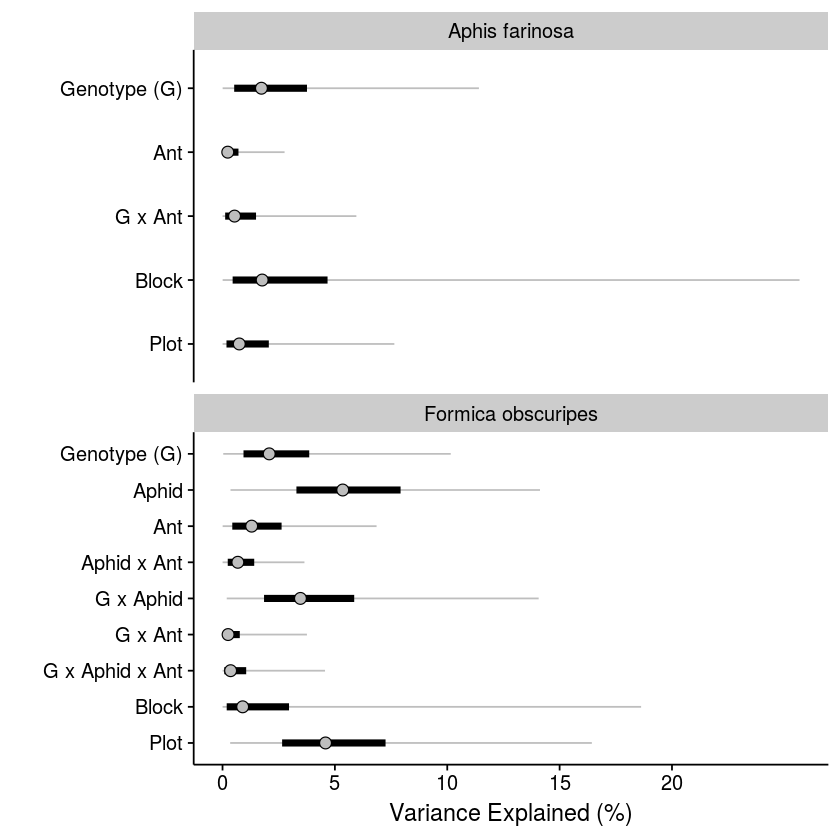

In [46]:

## BAYESIAN MIXED-EFFECT MODELS OF ANT-APHID INTERACTIONS ----

aphis.aa.2012.brm <- general_brm(scale(log(aphid_Aphis+1))~sc.Ant.mound.dist+(1+sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.arth.df)
summary(aphis.aa.2012.brm)

formica.aa.2012.brm <- general_brm(scale(log(ant_F_obscuripes+1))~sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.arth.df)
summary(formica.aa.2012.brm)


## CALCULATE POSTERIOR SD ESTIMATES ----

ant.aphid_SDs <- bind_rows(
  mutate(posterior_SDs(aphis.aa.2012.brm, df=aa.arth.df, FE_formula = "~sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Aphis farinosa"),
  mutate(posterior_SDs(formica.aa.2012.brm, df=aa.arth.df, FE_formula = "~sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Formica obscuripes")
)


## CALCULATE VARIANCE EXPLAINED IN ANT-APHID INTERACTIONS ----

aphis.var.df <- ant.aphid_SDs %>%  
  filter(Response == "Aphis farinosa") %>%
  transmute("Genotype (G)" =    sd_Genotype__Intercept^2 /                            (sd_Genotype__Intercept^2 + sd_sc.Ant.mound.dist^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Ant =               sd_sc.Ant.mound.dist^2 /                              (sd_Genotype__Intercept^2 + sd_sc.Ant.mound.dist^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Ant" =         sd_Genotype__sc.Ant.mound.dist^2 /                    (sd_Genotype__Intercept^2 + sd_sc.Ant.mound.dist^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Block =             sd_Block__Intercept^2 /                               (sd_Genotype__Intercept^2 + sd_sc.Ant.mound.dist^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Plot =              sd_Plot_code__Intercept^2 /                           (sd_Genotype__Intercept^2 + sd_sc.Ant.mound.dist^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            sample = sample, Experiment = Experiment, Year = Year, Response = Response) %>%
  gather(key = term, value = percent.variance, -(sample:Response))
      
formica.var.df <- ant.aphid_SDs %>% 
  filter(Response == "Formica obscuripes") %>%
  transmute("Genotype (G)" =    sd_Genotype__Intercept^2 /                            (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Aphid =             sd_sc.Aphid.treatment^2 /                             (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Ant =               sd_sc.Ant.mound.dist^2 /                              (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "Aphid x Ant" =     sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 /           (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Aphid" =       sd_Genotype__sc.Aphid.treatment^2 /                   (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Ant" =         sd_Genotype__sc.Ant.mound.dist^2 /                    (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Aphid x Ant" = sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 / (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Block =             sd_Block__Intercept^2 /                               (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Plot =              sd_Plot_code__Intercept^2 /                           (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            sample = sample, Experiment = Experiment, Year = Year, Response = Response) %>%
  gather(key = term, value = percent.variance, -(sample:Response)) 

## BIND & ORGANIZE DATA FOR PLOTTING ----

ant_aphid.var <- bind_rows(aphis.var.df, formica.var.df) %>% unite(Experiment_Year, Experiment, Year, sep = " ", remove = F)
ant_aphid.var$term <- factor(ant_aphid.var$term)
ant_aphid.var$term_ord <- factor(ant_aphid.var$term, levels=c("Plot","Block","G x Aphid x Ant","G x Ant","G x Aphid","G x Wind","Aphid x Ant","Ant","Aphid","Wind","Genotype (G)")) # "Soil PC2","Soil PC1", "Root C:N","Trait PC2","Trait PC1"

ant_aphid.GxE <- ggplot(ant_aphid.var, aes(x=term_ord, y=percent.variance)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.975), fun.ymin=function(y) quantile(y,0.025), geom="linerange", color="grey", size=0.5, position=position_dodge(width=0.75)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.75), fun.ymin=function(y) quantile(y,0.25), geom="linerange", color="black", size=2, position=position_dodge(width=0.75)) +
  stat_summary(fun.y = median, size=3, shape=21, fill="grey", position=position_dodge(width=0.75), geom="point") + 
  coord_flip() +
  ylab("Variance Explained (%)") +
  xlab("") +
  scale_y_continuous(breaks = c(0, 0.05, 0.1, 0.15, 0.2), labels=c(0, 5, 10, 15, 20)) +
  facet_wrap(~Response, ncol=1, scales = "free_y")
ant_aphid.GxE
# save_plot(filename = "manuscript/figures/fig_ant-aphid_GxE.png", plot = ant_aphid.GxE, base_height = 6, base_width = 8)


Analyses and plots that quantify sources of variation in arthropod species richness. Note that this analysis ignores measured trait variation, but is useful for assessing the effects of genetic variation in unmeasured plant traits. 

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.log1.Arthropod.Rich ~ sc.Aphid.treatment * sc.Ant.mound.dist + (1 + sc.Aphid.treatment * sc.Ant.mound.dist | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 284) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.28      0.20     0.03     0.79       1471 1.00

~Genotype (Number of levels: 10) 
                                                             Estimate Est.Error
sd(Intercept)                                                    0.48      0.15
sd(sc.Aphid.treatment)                                           0.09      0.08
sd(sc.Ant.mound.dist)                                            0.12      0.09
sd(sc.Aphid.treatment:sc.Ant.mound.dist

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.log1.Arthropod.Rich ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 186) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.18      0.13     0.01     0.46       1293 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.31      0.14     0.07     0.63       1254
sd(sc.Wind.Exposure)                0.11      0.08     0.00     0.32       2569
cor(Intercept,sc.Wind.Exposure)     0.06      0.56    -0.92     0.95       4000
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wi

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sc.log1.Arthropod.Rich ~ sc.Wind.Exposure + (1 + sc.Wind.Exposure | Genotype) + (1 | Block) + (1 | Plot_code) 
   Data: data (Number of observations: 176) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~Block (Number of levels: 10) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.30      0.17     0.02     0.66        733 1.00

~Genotype (Number of levels: 10) 
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                       0.18      0.12     0.01     0.46       1434
sd(sc.Wind.Exposure)                0.10      0.08     0.00     0.30       2443
cor(Intercept,sc.Wind.Exposure)    -0.10      0.57    -0.96     0.95       2966
                                Rhat
sd(Intercept)                   1.00
sd(sc.Wi

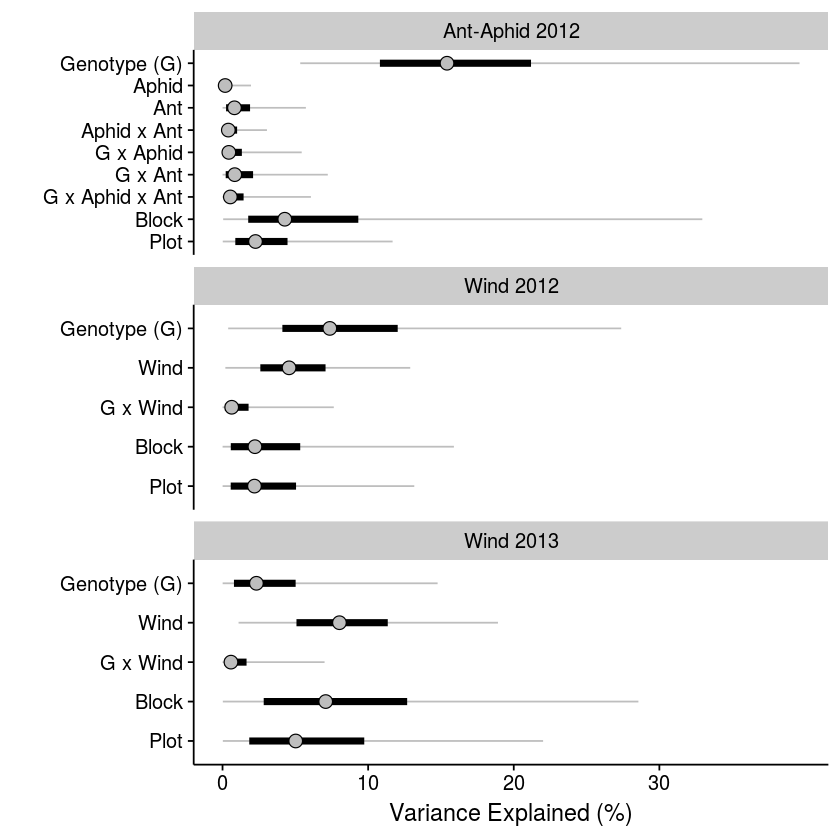

In [47]:

## BAYESIAN MIXED-EFFECT MODELS OF ARTHROPOD RICHNESS RESPONSES ----

arth.rich.aa.2012.brm <- general_brm(sc.log1.Arthropod.Rich~sc.Aphid.treatment*sc.Ant.mound.dist+(1+sc.Aphid.treatment*sc.Ant.mound.dist|Genotype)+(1|Block)+(1|Plot_code), data=aa.arth.df)
summary(arth.rich.aa.2012.brm)

arth.rich.wind.2012.brm <- general_brm(sc.log1.Arthropod.Rich~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.arth.2012)
summary(arth.rich.wind.2012.brm)

arth.rich.wind.2013.brm <- general_brm(sc.log1.Arthropod.Rich~sc.Wind.Exposure+(1+sc.Wind.Exposure|Genotype)+(1|Block)+(1|Plot_code), data=w.arth.2013)
summary(arth.rich.wind.2013.brm)


## CALCULATE POSTERIOR SD ESTIMATES ----

wind_arth_SDs <- bind_rows(
  mutate(posterior_SDs(arth.rich.wind.2012.brm, df=w.arth.2012, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2012", Response="Arthropod Richness"), 
  mutate(posterior_SDs(arth.rich.wind.2013.brm, df=w.arth.2013, FE_formula = "~sc.Wind.Exposure"), Experiment="Wind", Year="2013", Response="Arthropod Richness") 
)

ant.aphid_arth_SDs <- mutate(posterior_SDs(arth.rich.aa.2012.brm, df=aa.arth.df, FE_formula = "~sc.Aphid.treatment*sc.Ant.mound.dist"), Experiment="Ant-Aphid", Year="2012", Response="Arthropod Richness")


## CALCULATE VARIANCE EXPLAINED ----

wind.var.df <- wind_arth_SDs %>% 
  transmute("Genotype (G)" = sd_Genotype__Intercept^2 /        (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Wind =       sd_sc.Wind.Exposure^2 /           (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Wind" =     sd_Genotype__sc.Wind.Exposure^2 / (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Block =    sd_Block__Intercept^2 /           (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Plot =     sd_Plot_code__Intercept^2 /       (sd_Genotype__Intercept^2 + sd_sc.Wind.Exposure^2 + sd_Genotype__sc.Wind.Exposure^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            sample = sample, Experiment = Experiment, Year = Year, Response = Response) %>%
  gather(key = term, value = percent.variance, -(sample:Response)) 

aa.var.df <- ant.aphid_arth_SDs %>% 
  transmute("Genotype (G)" =    sd_Genotype__Intercept^2 /                            (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Aphid =             sd_sc.Aphid.treatment^2 /                             (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Ant =               sd_sc.Ant.mound.dist^2 /                              (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "Aphid x Ant" =     sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 /           (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Aphid" =       sd_Genotype__sc.Aphid.treatment^2 /                   (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Ant" =         sd_Genotype__sc.Ant.mound.dist^2 /                    (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            "G x Aphid x Ant" = sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 / (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Block =             sd_Block__Intercept^2 /                               (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            Plot =              sd_Plot_code__Intercept^2 /                           (sd_Genotype__Intercept^2 + sd_sc.Aphid.treatment^2 + sd_sc.Ant.mound.dist^2 + sd_sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment^2 + sd_Genotype__sc.Ant.mound.dist^2 + sd_Genotype__sc.Aphid.treatment.sc.Ant.mound.dist^2 + sd_Block__Intercept^2 + sd_Plot_code__Intercept^2 + sigma),
            sample = sample, Experiment = Experiment, Year = Year, Response = Response) %>%
  gather(key = term, value = percent.variance, -(sample:Response)) 


## BIND AND ORGANIZE DATA FOR PLOTTING ----

var.df <- bind_rows(wind.var.df, aa.var.df) %>% unite(Experiment_Year, Experiment, Year, sep = " ", remove = F)
var.df$term <- factor(var.df$term)
var.df$term_ord <- factor(var.df$term, levels=c("Plot","Block","G x Aphid x Ant","G x Ant","G x Aphid","G x Wind","Aphid x Ant","Ant","Aphid","Wind","Genotype (G)")) # "Soil PC2","Soil PC1", "Root C:N","Trait PC2","Trait PC1"


## MAKE PLOT ----

arth.GxE <- filter(var.df, Response == "Arthropod Richness") %>%
  ggplot(., aes(x=term_ord, y=percent.variance)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.975), fun.ymin=function(y) quantile(y,0.025), geom="linerange", color="grey", size=0.5, position=position_dodge(width=0.75)) +
  stat_summary(fun.ymax=function(y) quantile(y,0.75), fun.ymin=function(y) quantile(y,0.25), geom="linerange", color="black", size=2, position=position_dodge(width=0.75)) +
  stat_summary(fun.y = median, size=3.5, shape=21, fill="grey", position=position_dodge(width=0.75), geom="point") +
  coord_flip() +
  ylab("Variance Explained (%)") +
  xlab("") +
  scale_y_continuous(breaks = c(0, 0.1, 0.2, 0.3), labels=c(0, 10, 20, 30)) +
  facet_wrap(~Experiment_Year, ncol=1, scales = "free_y")
arth.GxE
# save_plot(filename = "manuscript/figures/fig_arthropod_GxE.png", plot = arth.GxE, base_height = 6, base_width = 8)
